# Advection Equation

In [1]:
# cd("..")

using LinearAlgebra
# using DifferentialEquations
using Plots

In [3]:
pwd()
# cd("..")

using Pkg
Pkg.activate(pwd())
using SBP_operators

This is a "copy" of Kenneth Duru's advection equation 

$$
    \frac{\partial v(x,t)}{\partial t} + c\frac{\partial v(x,t)}{\partial x} = 0
$$

With initial data $v(x,0) = 0$ and Dirichlet boundary conditions:
$$
    g(t) = \begin{cases} \sin^4(\pi/2t)     &\qquad \text{if }t\leq 2, \\
        0   &\qquad \text{if }t>2.
        \end{cases}
$$
Which has the exact solution
$$
    v(x,t) = g(t-x/c)
$$

The SBP approach gives boundary terms with

$$
    SAT_0 = \tau_0 H^{-1} e\_0 (u - g_0(t)) = \tau_0 (h_{00} \Delta x)^{-1} (u_0 - g_0(t))
$$

where $\tau_0 = 1/(h \Delta x)$

In [4]:
function ∂ₓu(uₓ,u,n,Δx,Δt,k,t,x,g;order=2)

    if order == 2
        τ = 1.0/(0.5Δx)
    elseif order == 4
        τ = 1.0/((17.0/48.0)Δx)
    end

    # Numerical derivative of u
    uₓ = -k*SBP_operators.Dₓ!(uₓ,u,n,Δx,order=order)

    # SAT
    uₓ[1] -= τ*(u[1] - g(t))

    return uₓ

end

∂ₓu (generic function with 1 method)

Boundary condition

In [5]:
function boundary_condition(t)
    g₀ = 0.

    if (0.0 ≤ t ≤ 2.0)
        g₀ = sin(π/2 * t)^4
    end

    return g₀
end

boundary_condition (generic function with 1 method)

## Time solver

In [9]:
function time_solver(u,RHS,Δt,Δx,k,t_f,boundary;method=:euler,order=2)

    N = ceil(Int64,t_f/Δt)
    n = size(u)[1]
    
    # Eulers method
    for i = 1:N-1
        t = i*Δt
        if method == :euler
            u[:,i+1] = u[:,i] + Δt*RHS(u[:,i+1],u[:,i],n,Δx,Δt,k,t,x,boundary,order=order)

        elseif method == :rk4
            k1 = RHS(u[:,i+1],u[:,i]        ,n,Δx,Δt,k,t        ,x,boundary)
            k2 = RHS(u[:,i+1],u[:,i]+Δt/2*k1,n,Δx,Δt,k,t+0.5Δt  ,x,boundary)
            k3 = RHS(u[:,i+1],u[:,i]+Δt/2*k2,n,Δx,Δt,k,t+0.5Δt  ,x,boundary)
            k4 = RHS(u[:,i+1],u[:,i]+Δt*k3  ,n,Δx,Δt,k,t+Δt     ,x,boundary)

            u[:,i+1] = u[:,i] + Δt/6 * (k1 + 2k2 + 2k3 + k4)

        end
    end

    return u
end

time_solver (generic function with 1 method)

Set the domain and time stepping

In [10]:
# Domain params
𝒟 = [0.0,10.0]
n = 101
k = 1.

Δx = 𝒟[2]/(n-1)

x = collect(range(𝒟[1],𝒟[2],step=Δx))

# Time stepping params
cfl = 0.5
t_f = 6.5
Δt = cfl/k*Δx

t_f = 6.5

N = ceil(Int64,t_f/Δt)

# Time stepping method
method=:rk4

println("Δt=",Δt)
println("Δx=",Δx)


Δt=0.05
Δx=0.1


Run the simulation

In [13]:
# Preallocate output
u = zeros(Float64,n,N)


# Push solution
u = time_solver(u,∂ₓu,Δt,Δx,k,t_f,boundary_condition,method=method,order=4)

101×130 Matrix{Float64}:
 0.0  0.000200779  0.00139768   0.00528863   …  -5.35323e-5   -0.000104251
 0.0  1.51254e-5   0.000176561  0.000913941      0.000174851   0.000181934
 0.0  1.14206e-6   1.98123e-5   0.0001369       -0.000173282  -4.11075e-5
 0.0  2.46707e-8   1.6075e-6    1.67719e-5      -0.000296819  -0.000381746
 0.0  0.0          1.12989e-7   1.78738e-6       0.000338268   0.000115057
 0.0  0.0          6.19084e-9   1.62633e-7   …   0.000476854   0.000593027
 0.0  0.0          2.50129e-10  1.26013e-8      -0.000395198  -6.53142e-5
 0.0  0.0          4.01542e-12  8.09659e-10     -0.000720916  -0.000794432
 0.0  0.0          0.0          4.31383e-11      0.000276016  -0.000155873
 0.0  0.0          0.0          1.78187e-12      0.000969181   0.000902512
 ⋮                                           ⋱                
 0.0  0.0          0.0          0.0              2.29373e-11   4.04717e-11
 0.0  0.0          0.0          0.0              8.51247e-12   1.51723e-11
 0.0  0.0     

┌ Info: Saved animation to 
│   fn = z:\Git-stuff\SBP_operators\yes.gif
└ @ Plots C:\Users\Spiff\.julia\packages\Plots\yiUpW\src\animation.jl:104


Plots.AnimatedGif("z:\\Git-stuff\\SBP_operators\\yes.gif")
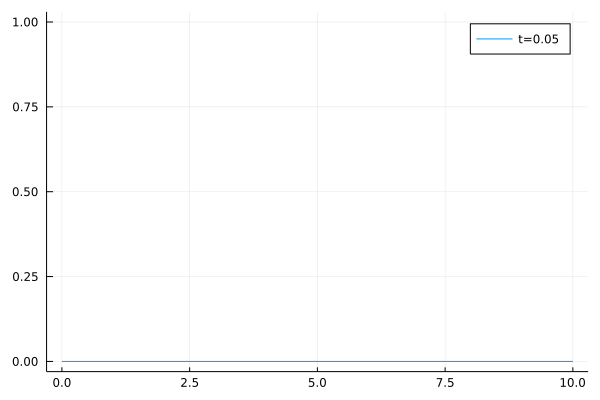

In [14]:
anim = @animate for i = 1:N
    plot(x,u[:,i],label=string("t=",i*Δt))
end

gif(anim,"yes.gif",fps=5)